# Lending Club Project
### What is the impact of using biased data when Predicting Probability of Default?


In [530]:
#data handling, model creation/evaluation
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from scipy import stats
from sklearn.metrics import roc_curve, auc
from matplotlib.ticker import FuncFormatter
import matplotlib
import matplotlib.pyplot as plt


#make it so that we only show first 4 decimals for floats
np.set_printoptions(precision=4,suppress=True)

# visualization
%matplotlib inline
import seaborn as sns

# http://analytics.ncsu.edu/sesug/2008/ST-160.pdf

In [119]:
# Import Accept data
AcceptData_Raw = pd.read_csv("../Lending_Club_Project/data/LoanStats.csv", skiprows=1, low_memory=False)

# Import Reject data
#https://web.archive.org/web/20111101213447/https://www.lendingclub.com/info/download-data.action
RejData_Raw = pd.read_csv("../Lending_Club_Project/data/rejected_2007_to_2016.csv")

In [3]:
# Create a copy of the dataset to modify, so do not to reimport original df
AcceptData = AcceptData_Raw.copy()
RejData = RejData_Raw.copy()

In [4]:
# Clean Column Names - remove blanks, set lowercase, etc.
AcceptData.columns = AcceptData.columns.str.lower().str.replace(" ","_").str.replace(".","").str.replace("(", "").str.replace(")", "").str.replace("-","")
RejData.columns = RejData.columns.str.lower().str.replace(" ","_").str.replace(".","").str.replace("(", "").str.replace(")", "").str.replace("-","")



In [5]:
# Basically data cleaning for Date Variables
RejData.application_date = pd.to_datetime(RejData.application_date, format="%Y-%m-%d")
AcceptData.application_date = pd.to_datetime(AcceptData.application_date, format="%Y-%m-%d")

print RejData.head()

print RejData.dtypes

   amount_requested application_date                        loan_title  \
0            1000.0       2007-05-26  Wedding Covered but No Honeymoon   
1            1000.0       2007-05-26                Consolidating Debt   
2           11000.0       2007-05-27       Want to consolidate my debt   
3            6000.0       2007-05-27                           waksman   
4            1500.0       2007-05-27                            mdrigo   

   risk_score debttoincome_ratio zip_code state employment_length  policy_code  
0       693.0                10%    481xx    NM           4 years            0  
1       703.0                10%    010xx    MA          < 1 year            0  
2       715.0                10%    212xx    MD            1 year            0  
3       698.0             38.64%    017xx    MA          < 1 year            0  
4       509.0              9.43%    209xx    MD          < 1 year            0  
amount_requested             float64
application_date      datetime64

In [6]:
RejData.columns

Index([u'amount_requested', u'application_date', u'loan_title', u'risk_score',
       u'debttoincome_ratio', u'zip_code', u'state', u'employment_length',
       u'policy_code'],
      dtype='object')

In [7]:
AcceptData.columns

Index([u'loan_id', u'amount_requested', u'amount_funded_by_investors',
       u'interest_rate', u'loan_length', u'application_date',
       u'application_expiration_date', u'issued_date', u'credit_grade',
       u'loan_title', u'loan_purpose', u'loan_description', u'monthly_payment',
       u'status', u'total_amount_funded', u'debttoincome_ratio',
       u'remaining_principal_funded_by_investors',
       u'payments_to_date_funded_by_investors', u'remaining_principal',
       u'payments_to_date', u'recoveries', u'collection_recovery_fee',
       u'screen_name', u'city', u'state', u'home_ownership', u'monthly_income',
       u'fico_range', u'earliest_credit_line', u'open_credit_lines',
       u'total_credit_lines', u'revolving_credit_balance',
       u'revolving_line_utilization', u'inquiries_in_the_last_6_months',
       u'accounts_now_delinquent', u'delinquent_amount',
       u'delinquencies_last_2_yrs', u'months_since_last_delinquency',
       u'public_records_on_file', u'months_since

In [8]:
RejData.shape
RejData.dtypes

amount_requested             float64
application_date      datetime64[ns]
loan_title                    object
risk_score                   float64
debttoincome_ratio            object
zip_code                      object
state                         object
employment_length             object
policy_code                    int64
dtype: object

In [9]:
AcceptData.shape

(329521, 45)

In [10]:
# We will only keep loans of 36 Month terms for full aging

AcceptData.loan_length.value_counts()

36 months    252623
60 months     76897
Name: loan_length, dtype: int64

In [11]:
# Concatenate the Two DFs with Diff Shapes
# First create file indicator with Rej = "Reject"
AcceptData["Rej_Ind"] = 0
RejData["Rej_Ind"] = 1

# stack the DataFrames on top of each other
Full_data = pd.concat([AcceptData, RejData], axis=0)
Full_data.head()

,Rej_Ind,accounts_now_delinquent,amount_funded_by_investors,amount_requested,application_date,application_expiration_date,city,code,collection_recovery_fee,credit_grade,...,remaining_principal_funded_by_investors,revolving_credit_balance,revolving_line_utilization,risk_score,screen_name,state,status,total_amount_funded,total_credit_lines,zip_code
0,0,0.0,800.0,7500.0,2007-06-07,2007-06-21,Attleboro,NaN,0.0,null,...,0.0,4175.0,51.5%,NaN,Kingtrite,MA,Fully Paid,7500.0,8.0,NaN
1,0,0.0,650.0,5000.0,2007-06-12,2007-06-26,Rockville,NaN,0.0,null,...,0.0,85607.0,0.7%,NaN,Laguna,MD,Fully Paid,5000.0,26.0,NaN
2,0,0.0,1325.0,5000.0,2007-06-12,2007-06-26,Framingham,NaN,0.0,null,...,0.0,9698.0,19.4%,NaN,MGDesousa,MA,Fully Paid,5000.0,20.0,NaN
3,0,0.0,875.0,8500.0,2007-06-13,2007-06-27,Greensboro,NaN,0.0,null,...,0.0,8847.0,26.9%,NaN,Radiothermal,NC,Fully Paid,8500.0,9.0,NaN
4,0,0.0,1075.0,2500.0,2007-06-15,2007-06-29,Lakewood,NaN,0.0,null,...,0.0,7274.0,13.1%,NaN,PMJ7671,CO,Fully Paid,2500.0,40.0,NaN


In [56]:
Full_data.tail()

,Rej_Ind,accounts_now_delinquent,amount_funded_by_investors,amount_requested,application_date,application_expiration_date,city,code,collection_recovery_fee,credit_grade,...,revolving_credit_balance,revolving_line_utilization,risk_score,screen_name,state,status,total_amount_funded,total_credit_lines,zip_code,app_year
11079381,1,NaN,NaN,10000.0,2016-12-31,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,590.0,NaN,OH,NaN,NaN,NaN,441xx,2016.0
11079382,1,NaN,NaN,10000.0,2016-12-31,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,MD,NaN,NaN,NaN,207xx,2016.0
11079383,1,NaN,NaN,1200.0,2016-12-31,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,686.0,NaN,CA,NaN,NaN,NaN,914xx,2016.0
11079384,1,NaN,NaN,25000.0,2016-12-31,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NM,NaN,NaN,NaN,880xx,2016.0
11079385,1,NaN,NaN,15000.0,2016-12-31,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,684.0,NaN,NY,NaN,NaN,NaN,113xx,2016.0


In [13]:
print "Accept Data shape: ", AcceptData.shape
print "Rej Data shape: ", RejData.shape
print "Combined Data shape: ", Full_data.shape

# sanity check
print "Reject Flag Count: ", Full_data.Rej_Ind.value_counts()

#vertical_stack.describe()

Accept Data shape:  (329521, 46)
Rej Data shape:  (11079386, 10)
Combined Data shape:  (11408907, 48)
Reject Flag Count:  1    11079386
0      329521
Name: Rej_Ind, dtype: int64


In [14]:
Full_data["app_year"] = Full_data.application_date.dt.year

In [15]:
Full_data.tail(3)

,Rej_Ind,accounts_now_delinquent,amount_funded_by_investors,amount_requested,application_date,application_expiration_date,city,code,collection_recovery_fee,credit_grade,...,revolving_credit_balance,revolving_line_utilization,risk_score,screen_name,state,status,total_amount_funded,total_credit_lines,zip_code,app_year
11079383,1,NaN,NaN,1200.0,2016-12-31,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,686.0,NaN,CA,NaN,NaN,NaN,914xx,2016.0
11079384,1,NaN,NaN,25000.0,2016-12-31,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NM,NaN,NaN,NaN,880xx,2016.0
11079385,1,NaN,NaN,15000.0,2016-12-31,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,684.0,NaN,NY,NaN,NaN,NaN,113xx,2016.0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x11cc93910>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x11ca93310>], dtype=object)

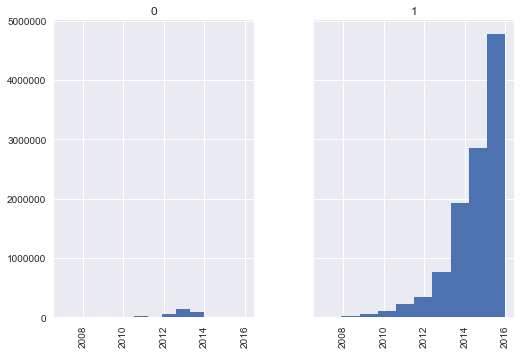

In [29]:
# Plot simple histogram of App Dates by Accept/Reject

Full_data['app_year'].hist(by=Full_data['Rej_Ind'], sharey=True, sharex=True)


In [25]:
AcceptData.application_date.describe()

count                  329520
unique                   2488
top       2014-04-15 00:00:00
freq                     1478
first     2007-05-25 00:00:00
last      2014-04-30 00:00:00
Name: application_date, dtype: object

In [55]:
RejData.application_date.describe()

count                11079386
unique                   3508
top       2016-07-05 00:00:00
freq                    31010
first     2007-05-26 00:00:00
last      2016-12-31 00:00:00
Name: application_date, dtype: object

In [596]:
# The most recent booked application is in April 30, 2014
# Since we are interested in default data we remove those accounts that have not properly aged

# Keep accounts that have application date prior to May 2011 (Both accepts and rejects)
# Remove accounts that were 60 month loans

Full_data_slim = Full_data[(Full_data['application_date'] < '2011-05-01') & (Full_data['loan_length'] != '60 months' )]


In [597]:
print "Loan Length Distribution:\n", Full_data_slim.loan_length.value_counts(dropna=False)

Loan Length Distribution:
NaN          264414
36 months     21109
Name: loan_length, dtype: int64


In [598]:
print "Overall Reject Rate: ", Full_data_slim.Rej_Ind.value_counts()[1] * 1.0 / Full_data_slim.shape[0]

Overall Reject Rate:  0.926069003198


In [650]:
#############################################
#############################################

Keep = RejData.columns.tolist()
Keep.append("fico_range")
Keep.append("status")

# Keep relevant columns
Full_data_slim2 = Full_data_slim[Keep]

In [651]:
#print Full_data_slim.head(5)
print Full_data_slim.shape

Full_data_slim.status.value_counts(dropna=False)

(285523, 49)


NaN                                                                  264414
Fully Paid                                                            16301
Charged Off                                                            2041
Does not meet the credit policy  Status: Fully Paid                    1786
Does not meet the credit policy  Status: Charged Off                    647
Current                                                                 264
Late (31-120 days)                                                       22
Default                                                                  21
Performing Payment Plan                                                  16
In Grace Period                                                           5
Does not meet the credit policy  Status: Late (31-120 days)               2
Does not meet the credit policy  Status: Performing Payment Plan          2
Late (16-30 days)                                                         1
Does not mee

In [652]:
#Full_data_slim2.dtypes

# Extract bounds from the FICO variable
#Full_data_slim2['fico_l'] = Full_data_slim2.fico_range.str[:3]

Full_data_slim2.loc[:, 'fico_l'] = Full_data_slim2['fico_range'].apply(lambda x: None if x == 'None' else float(str(x)[:3]))
Full_data_slim2.loc[:, 'fico_h'] = Full_data_slim2['fico_range'].apply(lambda x: None if x == 'None' else float(str(x)[-3:]))

#df['Date'].apply(lambda x: int(str(x)[-4:]))
#Full_data_slim2['fico_h'] = Full_data_slim2.fico_range.str[-3:]


In [653]:
# Compute the avg FICO score
Full_data_slim2.loc[:, 'fico_avg'] = Full_data_slim2[['fico_l', 'fico_h']].mean(axis=1)

# Get the final FICO score from the two columns
Full_data_slim2.loc[:, "FICO"] = Full_data_slim2[["fico_avg", "risk_score"]].max(axis=1)

# Convert DTI from String to Float
Full_data_slim2.debttoincome_ratio = pd.Series(Full_data_slim2.debttoincome_ratio).str.replace('%', '').astype(float)


In [654]:
Full_data_slim2.dtypes

amount_requested             float64
application_date      datetime64[ns]
loan_title                    object
risk_score                   float64
debttoincome_ratio           float64
zip_code                      object
state                         object
employment_length             object
policy_code                  float64
Rej_Ind                        int64
fico_range                    object
status                        object
fico_l                       float64
fico_h                       float64
fico_avg                     float64
FICO                         float64
dtype: object

In [655]:
Full_data_slim2.employment_length.value_counts(dropna=False)

< 1 year     150770
10+ years     27144
2 years       21315
1 year        20913
3 years       16419
4 years       12538
5 years       10426
6 years        7374
7 years        5469
8 years        5262
9 years        4389
n/a            3504
Name: employment_length, dtype: int64

In [656]:
# rename DTI column
Full_data_slim2.rename(columns = {'debttoincome_ratio':'dti'}, inplace = True)


In [657]:
# Need to Impute FICO score of 0 and NaN !!!
#Full_data_slim2.FICO.value_counts(dropna=False)


mapp_emp = {
        "10+ years": 10,
        "9 years": 9,
        "8 years": 8,
        "7 years": 7,
        "6 years": 6,
        "5 years": 5,
        "4 years": 4,
        "3 years": 3,
        "2 years": 2,
        "1 year": 1,
        "< 1 year": 0,
        "n/a": 0
    }

mapp_stat = {
        "Fully Paid": 0,
        "Charged Off": 1,
        "Does not meet the credit policy  Status: Fully Paid": 0,
        "Does not meet the credit policy  Status: Charged Off": 1,
        "Current": 0,
        "Late (31-120 days)": 1,
        "Default": 1,
        "Performing Payment Plan": 0,
        "In Grace Period": 0,
        "Does not meet the credit policy  Status: Late (31-120 days)": 1,
        "Does not meet the credit policy  Status: Performing Payment Plan": 0,
        "n/a": 0
    }

Full_data_slim2.loc[:,'emp_length_num'] = Full_data_slim2['employment_length'].map(mapp_emp)

Full_data_slim2.loc[:,'Bad_Ind'] = Full_data_slim2['status'].map(mapp_stat)

# Drop some unneeded Columns
Full_data_slim2 = Full_data_slim2.drop(['fico_l','fico_h', 'fico_range', 'fico_avg', 'policy_code', 'risk_score', 'loan_title', 'zip_code', 'employment_length'], axis=1)

# Clean FICO - with imputation
Full_data_slim2['FICO'].replace(np.nan, 590,inplace=True)
Full_data_slim2['FICO'].replace(0, 590,inplace=True)



In [658]:
#Full_data_slim2.stat_clean.value_counts(dropna=False)

CrossT = pd.crosstab(index=Full_data_slim2["status"], 
                    columns=Full_data_slim2["Bad_Ind"], margins=True, dropna=False)
CrossT

Bad_Ind,0.0,1.0,All
status,,,
Charged Off,0,2041,2041
Current,264,0,264
Default,0,21,21
Does not meet the credit policy Status: Charged Off,0,647,647
Does not meet the credit policy Status: Fully Paid,1786,0,1786
Does not meet the credit policy Status: Late (31-120 days),0,2,2
Fully Paid,16301,0,16301
In Grace Period,5,0,5
Late (31-120 days),0,22,22


In [659]:
Full_data_slim2.status.value_counts(dropna=False)

NaN                                                                  264414
Fully Paid                                                            16301
Charged Off                                                            2041
Does not meet the credit policy  Status: Fully Paid                    1786
Does not meet the credit policy  Status: Charged Off                    647
Current                                                                 264
Late (31-120 days)                                                       22
Default                                                                  21
Performing Payment Plan                                                  16
In Grace Period                                                           5
Does not meet the credit policy  Status: Late (31-120 days)               2
Does not meet the credit policy  Status: Performing Payment Plan          2
Late (16-30 days)                                                         1
Does not mee

In [660]:
Full_data_slim2.groupby('Rej_Ind').mean()

,amount_requested,dti,FICO,emp_length_num,Bad_Ind
Rej_Ind,,,,,
0,9568.171159,12.831805,714.176607,4.368326,0.129594
1,10867.651533,1836.738904,623.364372,2.111972,NaN


In [661]:
# Create train and holdout data
# Train & Test

keep_cols = ['FICO', 'dti', 'emp_length_num', 'Bad_Ind', 'Rej_Ind'] 

X = Full_data_slim2[keep_cols]
y = Full_data_slim2.Bad_Ind

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)


In [662]:
# Filter data for Target Populated
# Booked w/ Performance
ModelDataAccept = X_train[(X_train['Bad_Ind'] >= 0)]

#Non Booked Data (May include Not Taken Ups)
ModelDataRej = X_train[(pd.isnull(X_train.Bad_Ind))]

#ModelDataAccept.describe()

In [663]:
print "Full Data", Full_data_slim2.shape
print "Accept Data", ModelDataAccept.shape
print "Rej Data", ModelDataRej.shape

#ModelDataRej.tail()
#ModelDataRej.FICO.value_counts(dropna=False)

Full Data (285523, 9)
Accept Data (14761, 5)
Rej Data (185105, 5)


In [664]:
# 'FICO', 'debttoincome_ratio', 'emp_length_num'
#sns.plt.hist(ModelDataRej.debttoincome_ratio)

ModelDataAccept.dti.describe()

count    14761.000000
mean        12.815122
std          6.777862
min          0.000000
25%          7.460000
50%         12.850000
75%         18.190000
max         29.950000
Name: dti, dtype: float64

In [665]:
ModelDataRej.dti.tail()

173169    25.61
171367     1.11
6921      80.18
256760     8.21
228233    16.93
Name: dti, dtype: float64

In [666]:
#Variable Avg by Good/Bad
ModelDataAccept.groupby('Bad_Ind').mean()


,FICO,dti,emp_length_num,Rej_Ind
Bad_Ind,,,,
0.0,716.343604,12.727479,4.372004,0.0
1.0,699.254584,13.405160,4.254584,0.0


In [667]:
ModelDataRej.describe()

,FICO,dti,emp_length_num,Bad_Ind,Rej_Ind
count,185105.000000,1.851050e+05,185105.000000,0.0,185105.000000
mean,623.414457,1.826362e+03,2.113941,NaN,0.999941
std,79.455332,2.420481e+04,3.259530,NaN,0.007709
min,363.000000,-1.000000e+00,0.000000,NaN,0.000000
25%,588.000000,3.230000e+00,0.000000,NaN,1.000000
50%,629.000000,1.566000e+01,0.000000,NaN,1.000000
75%,683.000000,3.048000e+01,3.000000,NaN,1.000000
max,849.000000,3.626400e+06,10.000000,NaN,1.000000


In [668]:
# Good Rate for Booked Accounts
ModelDataAccept.Bad_Ind.value_counts()[0] * 1.0 / ModelDataAccept.shape[0]

0.87067271865049789

In [449]:
#outcome_pred = logreg.predict(X)
#y_pred = np.where(outcome_pred_class_log >= 0.18, 1, 0)

#print "Model accuracy:", metrics.accuracy_score(y, y_pred)
#print "Model ROC: ", metrics.classification_report(y, y_pred) 

In [692]:
# Fit a logistic regression Model
logreg = LogisticRegression(C=1e9)

#, 'amount_requested'
feature_cols = ['FICO', 'dti', 'emp_length_num']
X_V1 = ModelDataAccept[feature_cols]
y_V1 = ModelDataAccept.Bad_Ind

logreg.fit(X_V1, y_V1)
# store the predicted probabilities
predicted_logreg = logreg.predict_proba(X_V1)[:, 1]

# evaluate the model using 10-fold cross-validation
scores = cross_val_score(logreg, X_V1, y_V1, scoring='accuracy', cv=5)

print scores
print "10 Fold Cross Validation, Avg Score:", scores.mean()

logreg.fit(X_V1, y_V1)
print "\n Parameters: \n", logreg.coef_


print "\n Avg. Predicted Default Prob:", 1 - logreg.predict_proba(X_V1)[:, 1].mean()

[ 0.8706  0.8706  0.8706  0.8706  0.8709]
10 Fold Cross Validation, Avg Score: 0.870672737884

 Parameters: 
[[-0.0066  0.0119 -0.002 ]]

 Avg. Predicted Default Prob: 0.871919213599


In [694]:
# Fitting Random Forest
rf_model = RandomForestClassifier(max_depth=2, random_state=120, n_estimators = 50)

rf_model.fit(X_V1, y_V1)
predicted_probs_rf = rf_model.predict_proba(X_V1)[:, 1]

# print "Train accuracy: ", metrics.accuracy_score(y_V1, rf_model.predict(X_V1))

#### Cross Validation
cross_val_scores_RF = cross_val_score(rf_model, X_V1, y_V1, cv=10)
print "10-fold accuracies:\n", cross_val_scores_RF
print "Mean cv-accuracy:", np.mean(cross_val_scores_RF)



10-fold accuracies:
[ 0.8707  0.8707  0.8706  0.8706  0.8706  0.8706  0.8706  0.8706  0.8706
  0.8712]
Mean cv-accuracy: 0.870672751951


In [695]:
print "Logistic model AUC: ", metrics.roc_auc_score(y_V1, predicted_logreg)
print "Random Forest model AUC: ", metrics.roc_auc_score(y_V1, predicted_probs_rf)


LR model AUC:  0.62738124177
RF model AUC:  0.635742743637


In [696]:
# Score the NonBooked Accounts with Logistic Reg
X_rej = ModelDataRej[feature_cols]

print "Avg. PD of NonBooked", logreg.predict_proba(X_rej)[:, 1].mean()
print "Avg. PD of Booked", logreg.predict_proba(X_V1)[:, 1].mean()

Avg. PD of NonBooked 0.254843995944
Avg. PD of Booked 0.128080786401


(array([   58.,   208.,   298.,   480.,   602.,   742.,   847.,   937.,
         1031.,  1152.,  1102.,  1196.,  1212.,  1186.,  1073.,   905.,
          696.,   473.,   283.,   168.,    49.,    27.,    13.,     5.,
            4.,     6.,     2.,     3.,     1.,     2.]),
 array([ 0.0563,  0.063 ,  0.0697,  0.0763,  0.083 ,  0.0897,  0.0964,
         0.1031,  0.1097,  0.1164,  0.1231,  0.1298,  0.1365,  0.1431,
         0.1498,  0.1565,  0.1632,  0.1699,  0.1765,  0.1832,  0.1899,
         0.1966,  0.2033,  0.2099,  0.2166,  0.2233,  0.23  ,  0.2367,
         0.2433,  0.25  ,  0.2567]),
 <a list of 30 Patch objects>)

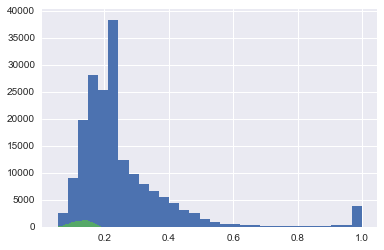

In [697]:
# Histogram of Probabilities
Rej_Pred = logreg.predict_proba(X_rej)[:, 1]
Accept_Pred = logreg.predict_proba(X_V1)[:, 1]

sns.plt.hist(Rej_Pred, bins=30)
sns.plt.hist(Accept_Pred, bins=30)


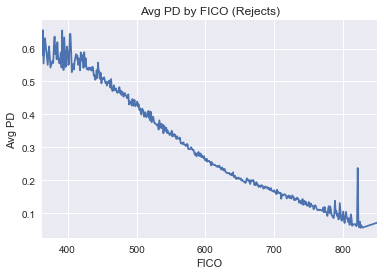

In [700]:
# Append PD to Dataset. Note: Here we predict the PDs of the NonBooked
ModelDataRej.loc[:,"PD"]    = logreg.predict_proba(X_rej)[:, 1]
ModelDataAccept.loc[:,"PD"] = logreg.predict_proba(X_V1)[:, 1]


# Plots by Diff Groups
FICO_rej_grp = ModelDataRej.groupby("FICO")
FICO_Means_Rej = FICO_rej_grp["PD"].agg(np.mean) #3  Mean of Soda Prices

FICO_Means_Rej.plot(title="Avg PD by FICO (Rejects)") #5
sns.plt.ylabel("Avg PD") #6


(array([ 0.0382,  0.1236,  0.1907,  0.2337,  0.2351,  0.1405,  0.0339,
         0.003 ,  0.0008,  0.0004]),
 array([ 0.0563,  0.0763,  0.0964,  0.1164,  0.1365,  0.1565,  0.1765,
         0.1966,  0.2166,  0.2367,  0.2567]),
 <a list of 10 Patch objects>)

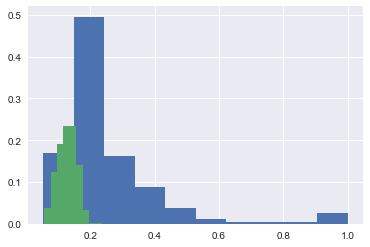

In [701]:
# http://stackoverflow.com/questions/3866520/plotting-histograms-whose-bar-heights-sum-to-1-in-matplotlib/16399202#16399202

#ModelDataRej.hist(bins=20, weights=np.ones_like(ModelDataRej[ModelDataRej.columns[0]]) * 100. / len(ModelDataRej))
weights_Rej = np.ones_like(ModelDataRej.PD)/len(ModelDataRej.PD)
weights_Acc = np.ones_like(ModelDataAccept.PD)/len(ModelDataAccept.PD)

sns.plt.hist(ModelDataRej.PD, weights=weights_Rej, bins=10)
sns.plt.hist(ModelDataAccept.PD, weights=weights_Acc, bins=10)


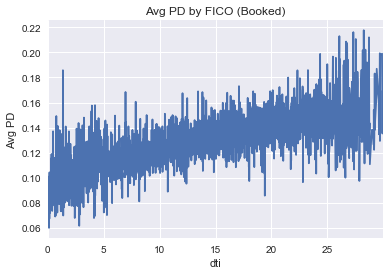

In [703]:

# Plots by Diff Groups
FICO_acc_grp = ModelDataAccept.groupby("dti")
FICO_Means_Acc = FICO_acc_grp["PD"].agg(np.mean) #3  Mean of Soda Prices

FICO_Means_Acc.plot(title="Avg PD by FICO (Booked)") #5
sns.plt.ylabel("Avg PD") #6


In [705]:
# stack the DataFrames on top of each other
# Assign Inferred Good/Bad for NonBooked Accounts. 
# For NonBooked use PD, for booked, copy Bad_Ind

ModelDataRej.loc[:, 'Bad_Ind_Inf'] = ModelDataRej['PD'].apply(lambda x: 1 if x >= 0.29 else 0)
ModelDataAccept.loc[:, 'Bad_Ind_Inf'] = ModelDataAccept['Bad_Ind']

ModelFull_data = pd.concat([ModelDataAccept, ModelDataRej], axis=0)


In [708]:
print "Reject Inferred Good/Bad: \n",ModelDataRej.Bad_Ind_Inf.value_counts()
print "\nBooked Good/Bad: \n", ModelDataAccept.Bad_Ind.value_counts()
print "\nAll Good/Bad: \n", ModelFull_data.Bad_Ind_Inf.value_counts()
print "\nRej Inferred Bad Rate:", ModelDataRej.Bad_Ind_Inf.value_counts()[1] * 1.0 / ModelDataRej.shape[0]
print "\nBad Rate of Full Dataset:", ModelFull_data.Bad_Ind_Inf.value_counts()[1] * 1.0 / ModelFull_data.shape[0]

Reject Inferred Good/Bad: 
0    140397
1     44708
Name: Bad_Ind_Inf, dtype: int64

Booked Good/Bad: 
0.0    12852
1.0     1909
Name: Bad_Ind, dtype: int64

All Good/Bad: 
0.0    153249
1.0     46617
Name: Bad_Ind_Inf, dtype: int64

Rej Inferred Bad Rate: 0.241527781529

Bad Rate of Full Dataset: 0.233241271652


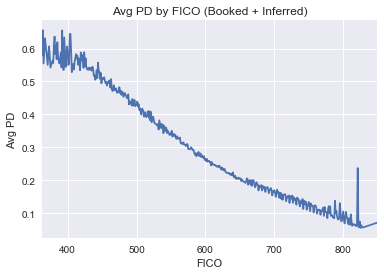

In [709]:
# Plots by Diff Groups
FICO_full_grp = ModelFull_data.groupby("FICO")
FICO_Means_full = FICO_full_grp["PD"].agg(np.mean) #3  Mean of Soda Prices

FICO_Means_full.plot(title="Avg PD by FICO (Booked + Inferred)") #5
sns.plt.ylabel("Avg PD") #6


In [710]:
# Fit a logistic regression Model on Full Data
logreg_Full = LogisticRegression(C=1e9)

#, 'amount_requested'
feature_cols = ['FICO', 'dti', 'emp_length_num']
X_full = ModelFull_data[feature_cols]
y_full = ModelFull_data.Bad_Ind_Inf # Includes Inferred Good/Bad

# store the predicted probabilities
#outcome_pred_prob_log = logreg.predict_proba(X)[:, 1]# evaluate the model using 10-fold cross-validation
scores_full = cross_val_score(LogisticRegression(), X_full, y_full, scoring='accuracy', cv=10)

print scores_full
print "10 Fold Cross Validation, Avg Score:", scores_full.mean()

logreg_Full.fit(X_full, y_full)
print "\n Parameters: \n", logreg_Full.coef_


print "\n Avg. Predicted Default Prob:", logreg_Full.predict_proba(X_full)[:, 1].mean()

[ 0.8971  0.9763  0.9092  0.9584  0.9722  0.9808  0.9797  0.9789  0.9847
  0.9751]
10 Fold Cross Validation, Avg Score: 0.961249381534

 Parameters: 
[[-0.0197  0.0503  0.0302]]

 Avg. Predicted Default Prob: 0.222152736768


In [717]:
#logreg.predict_proba(X_test)[:, 1]
X_test.describe()

,FICO,dti,emp_length_num,Bad_Ind,Rej_Ind
count,85657.000000,8.565700e+04,85657.000000,6328.000000,85657.000000
mean,629.993614,1.723998e+03,2.276918,0.130215,0.926019
std,80.628879,2.391919e+04,3.331372,0.336566,0.261742
min,368.000000,-1.000000e+00,0.000000,0.000000,0.000000
25%,590.000000,3.700000e+00,0.000000,0.000000,1.000000
50%,639.000000,1.518000e+01,0.000000,0.000000,1.000000
75%,691.000000,2.923000e+01,4.000000,0.000000,1.000000
max,832.000000,3.967200e+06,10.000000,1.000000,1.000000


In [720]:
# Predict test dataset - Booked Only
Test_Booked = X_test[(X_test['Bad_Ind'] >= 0)]

feature_cols = ['FICO', 'dti', 'emp_length_num']
X_test_data = Test_Booked[feature_cols]
Y_test_data = Test_Booked.Bad_Ind

predicted_logreg      = logreg.predict_proba(X_test_data)[:, 1]
predicted_logreg_full = logreg_Full.predict_proba(X_test_data)[:, 1]


print "\nTest accuracy for Model V1: ", metrics.roc_auc_score(Y_test_data, predicted_logreg)
print "\nTest accuracy for Model V2: ", metrics.roc_auc_score(Y_test_data, predicted_logreg_full)

#print "\nTest accuracy for Model V1: ", metrics.accuracy_score(Y_test_data, logreg.predict(X_test_data))
#print "\nTest accuracy for Model V2: ", metrics.accuracy_score(Y_test_data, logreg_Full.predict(X_test_data))


# Append Predicted PD from Booked LogRegModel
#X_test_data.loc[:,"PD_Booked"] = logreg.predict_proba(X_test_data)[:, 1]



Test accuracy for Model V1:  0.624959980561

Test accuracy for Model V2:  0.623558087499


In [712]:
X_test_final

,FICO,dti,emp_length_num
82996,677.0,69.66,7
77313,604.0,23.72,1
45075,717.0,26.46,3
12719,733.0,270.70,0
11583,641.0,60.03,0
68158,646.0,24.74,3
153503,704.0,5.00,0
54928,743.0,37.71,10
169285,685.0,52.85,0
140377,590.0,-1.00,0
